# Cthulhu News Draft One

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pickle
import random
import time
from collections import Counter
from datetime import datetime, timedelta, timezone
from difflib import SequenceMatcher
from pathlib import Path
from string import punctuation

import httpx
import matplotlib.pyplot as plt
import newspaper
import nltk
import numpy as np
import pandas as pd
import spacy
import spacy.cli
import spacy.displacy
import spacy.tokens
from dotenv import load_dotenv
from envparse import env
from loguru import logger
from logutil import init_loguru
from openai import OpenAI
from tenacity import retry, stop_after_attempt

In [3]:
np.random.seed(42**3)
load_dotenv()

True

In [4]:
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /Users/nameless/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nameless/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
# spacy_model_name = "en_core_web_sm"
spacy_model_name = "en_core_web_md"
# spacy_model_name = "en_core_web_lg"
# spacy_model_name = "en_core_web_trf"

try:
    spacy_nlp = spacy.load(spacy_model_name)
    logger.debug(f"loaded spacy model name='{spacy_model_name}' path='{spacy_nlp.path}'")
except Exception as e:
    logger.debug(str(e))
    spacy.cli.download(spacy_model_name)
    logger.debug(f"downloaded spacy model from web name='{spacy_model_name}'")
    spacy_nlp = spacy.load(spacy_model_name)
    logger.debug(f"loaded spacy model name='{spacy_model_name}' path='{spacy_nlp.path}'")

2024-11-22 10:39:16.482 | DEBUG    | __main__:<module>:8 - loaded spacy model name='en_core_web_md' path='/Users/nameless/dev/proj/cthulhu-news/.venv/lib/python3.12/site-packages/en_core_web_md/en_core_web_md-3.8.0'


2024-11-22T09:39:19.815Z __main__ DEBUG: this is a test log line


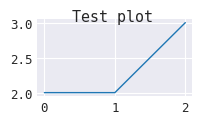

In [7]:
init_loguru()
logger.debug("this is a test log line")

# plt.style.use('ggplot')
# plt.style.use('dark_background')
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 9

plt.figure(figsize=(2, 1))
plt.plot([0, 1, 2], [2, 2, 3])
plt.suptitle("Test plot")

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

In [8]:
GNEWS_API_KEY = env.str("GNEWS_API_KEY")
print(GNEWS_API_KEY[-3:])
GNEWS_URL = "https://gnews.io/api/v4/search"

MONGO_USER = env.str("MONGO_INITDB_ROOT_USERNAME")
MONGO_PASSWORD = env.str("MONGO_INITDB_ROOT_PASSWORD")
MONGO_HOST = env.str("MONGO_HOST")
MONGO_PORT = env.int("MONGO_PORT")
MONGODB_URI = f"mongodb://{MONGO_USER}:{MONGO_PASSWORD}@{MONGO_HOST}:{MONGO_PORT}?retryWrites=true&w=majority"
print(MONGODB_URI[:11])

OPENAI_API_KEY = env.str("OPENAI_API_KEY")
print(OPENAI_API_KEY[-3:])

4df
mongodb://a
gsV


In [9]:
def default_json_converter(o):
    if isinstance(o, datetime):
        return o.isoformat()
    raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")

## Get news listings

... using GNews.io

In [10]:
time_now = datetime.now(tz=timezone.utc)
news_listings = []
for query in ["finance", "politics", "murder", "funny"]:
    params = {
        "q": query,
        "lang": "en",
        "max": 10,
        "from": (time_now - timedelta(hours=24 * 2)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        # "to": ,
        # "sortby": "publishedAt",
        "sortby": "relevance",
        "apikey": GNEWS_API_KEY,
    }

    response = httpx.get(GNEWS_URL, params=params)

    data = json.loads(response.read().decode("utf-8"))
    if "articles" in data:
        news_listings.extend(data["articles"])

        print(query, len(data["articles"]))
        for listing in data["articles"]:
            print(f"Title: {listing['title']}")
    else:
        print(data)
    time.sleep(1)

finance 10
Title: India at CoP-29: Push for climate finance and strengthen domestic sources
Title: India Challenges Shift in Climate Finance Focus at COP29
Title: Standoff at COP29: Developing Nations Demand Concrete Climate Finance Commitment
Title: With 2 days left, new COP29 climate finance draft text is out-but the actual number is missing
Title: Still no number for new climate finance goal as COP29 reaches final hours
Title: COP29 climate finance proposal reveals wide gaps between rich & developing nations
Title: B.C.'s new finance minister looking to balance competing demands
Title: Khurram Schehzad appointed adviser to finance minister
Title: Climate finance talks face 'hardest' stage as COP29 nears endgame
Title: Q1 2025 Crypto Price Predictions: Solana (SOL) to $714, Ripple (XRP) to $8.30, and Rexas Finance (RXS) to $11
politics 10
Title: ‘We didn’t intend to create outrage’: Huggy Bear on radical politics, riot grrrl - and causing chaos on live TV
Title: Is a left-wing party 

In [11]:
NEWS_SIMILARITY_CUTOFF = 0.5


def str_to_key(string: str) -> str:
    return "".join(x for x in string.lower() if x.isalnum() or x == "_")


encoded_titles = []
unique_news_listings = []

for listing in news_listings:
    encoded_title = str_to_key(listing["title"])
    if len(encoded_titles) == 0:
        similarity = 0
    else:
        similarity = max([SequenceMatcher(None, encoded_title, x).ratio() for x in encoded_titles])
    if similarity > NEWS_SIMILARITY_CUTOFF:
        print("exclude title", listing["title"])
    else:
        encoded_titles.append(encoded_title)
        unique_news_listings.append(listing)

print(len(news_listings), len(unique_news_listings))

exclude title Washington Post abruptly ousts politics editor Dan Eggen after Trump win: report
exclude title Man found guilty of murder in the killing of Georgia nursing student Laken Riley
37 35


In [12]:
news_articles = []
for listing in unique_news_listings:
    article = {}
    article["title"] = listing["title"]
    article["description"] = listing["description"]
    article["partial_text"] = listing["content"]
    article["url"] = listing["url"]
    # formatted_news_link["image"] = news_link["image"]
    article["published_at"] = datetime.strptime(listing["publishedAt"], r"%Y-%m-%dT%H:%M:%S%z")
    article["media_source_name"] = listing["source"]["name"]
    article["media_source_url"] = (
        listing["source"]["url"].replace("http://", "").replace("https://", "")
    )
    listing["partial_text"] = listing["content"]
    article["listing_query"] = query
    article["listing_source"] = "gnews"
    news_articles.append(article)

print(len(news_articles))

35


## Download full news articles

...using newspaper

In [13]:
for listing in news_articles:
    try:
        page = newspaper.Article(listing["url"])
        page.download()
        page.parse()
        page.nlp()
        time.sleep(2)
    except Exception as e:
        logger.error(e)
    else:
        listing["full_text"] = page.text
        listing["full_html"] = page.html
        listing["tags"] = list(page.tags)
        listing["nltk_summary"] = page.summary
        listing["nltk_keywords"] = page.keywords
        logger.debug(f"downloaded and parsed news article title='{listing['title']}'")
logger.info(f"downloaded and parsed full news articles count={len(news_articles)}")

2024-11-22T09:39:31.640Z __main__ DEBUG: downloaded and parsed news article title='India at CoP-29: Push for climate finance and strengthen domestic sources'
2024-11-22T09:39:35.077Z __main__ DEBUG: downloaded and parsed news article title='India Challenges Shift in Climate Finance Focus at COP29'
2024-11-22T09:39:38.756Z __main__ DEBUG: downloaded and parsed news article title='Standoff at COP29: Developing Nations Demand Concrete Climate Finance Commitment'
2024-11-22T09:39:41.240Z __main__ DEBUG: downloaded and parsed news article title='With 2 days left, new COP29 climate finance draft text is out-but the actual number is missing'
2024-11-22T09:39:44.078Z __main__ DEBUG: downloaded and parsed news article title='Still no number for new climate finance goal as COP29 reaches final hours'
2024-11-22T09:39:46.754Z __main__ DEBUG: downloaded and parsed news article title='COP29 climate finance proposal reveals wide gaps between rich & developing nations'
2024-11-22T09:39:49.801Z __main_

In [14]:
print(len(news_articles))
news_articles = [listing for listing in news_articles if "full_text" in listing]
print(len(news_articles))

35
33


## Spacy NLP

In [15]:
def get_spacy_keywords(doc: spacy.tokens.doc.Doc, n: int = 10) -> list[tuple[str, int]]:
    hotwords = []
    pos_tag = ["PROPN", "ADJ", "NOUN"]
    for token in doc:
        if token.text in spacy_nlp.Defaults.stop_words or token.text in punctuation:
            continue
        if token.pos_ in pos_tag:
            hotwords.append(token.text.lower())
    keywords = list(Counter(hotwords).most_common(n))
    return keywords


def get_spacy_entities(doc: spacy.tokens.doc.Doc) -> dict[str, list[str]]:
    entities = {}
    for ent_type in {"PERSON", "GPE", "ORG"}:
        entities[ent_type] = set([ent.text for ent in doc.ents if ent.label_ == ent_type])
    return entities

In [16]:
type(listing["spacy_persons"])

KeyError: 'spacy_persons'

In [17]:
for listing in news_articles:
    sdoc = spacy_nlp(listing["full_text"])
    listing["_spacy_doc"] = sdoc
    listing["spacy_keywords_1"] = get_spacy_keywords(sdoc, n=10)
    spacy_entities = get_spacy_entities(sdoc)
    listing["spacy_persons"] = list(spacy_entities["PERSON"])
    listing["spacy_locations"] = list(spacy_entities["GPE"])
    listing["spacy_organisations"] = list(spacy_entities["ORG"])
    logger.debug(f"spacy nlp for news article title='{listing['title']}'")

2024-11-22T09:48:54.325Z __main__ DEBUG: spacy nlp for news article title='India at CoP-29: Push for climate finance and strengthen domestic sources'
2024-11-22T09:48:54.340Z __main__ DEBUG: spacy nlp for news article title='India Challenges Shift in Climate Finance Focus at COP29'
2024-11-22T09:48:54.353Z __main__ DEBUG: spacy nlp for news article title='Standoff at COP29: Developing Nations Demand Concrete Climate Finance Commitment'
2024-11-22T09:48:54.429Z __main__ DEBUG: spacy nlp for news article title='With 2 days left, new COP29 climate finance draft text is out-but the actual number is missing'
2024-11-22T09:48:54.484Z __main__ DEBUG: spacy nlp for news article title='Still no number for new climate finance goal as COP29 reaches final hours'
2024-11-22T09:48:54.517Z __main__ DEBUG: spacy nlp for news article title='COP29 climate finance proposal reveals wide gaps between rich & developing nations'
2024-11-22T09:48:54.592Z __main__ DEBUG: spacy nlp for news article title='B.C.'

In [18]:
i = 0
spacy_doc = news_articles[0]["_spacy_doc"]
spacy.displacy.render(news_articles[i]["_spacy_doc"], style="ent")
print(news_articles[i]["spacy_keywords_1"])
print(news_articles[i]["spacy_persons"])
print(news_articles[i]["spacy_locations"])
print(news_articles[i]["spacy_organisations"])

[('climate', 28), ('india', 19), ('banks', 11), ('finance', 9), ('financial', 9), ('transition', 8), ('risk', 8), ('global', 7), ('sector', 5), ('indian', 5)]
[]
['Azerbaijan', 'India', 'Baku']
['India Program', 'HSBC', 'Reserve Bank of India', 'the Indian Banks’ Association', 'RMI', 'the New Collective Quantified Goal (NCQG', 'Barclays’ ‘Bluetrack’']


In [19]:
spacy_doc = news_articles[0]["_spacy_doc"]
df = pd.DataFrame([{"text": ent.text, "label": ent.label_} for ent in spacy_doc.ents]).sort_values(
    ["label", "text"]
)
display(df.loc[df["label"].isin(["GPE", "ORG", "PERSON", "DATE"]), :])
spacy.displacy.render(spacy_doc, style="ent")

,text,label
10,annually,DATE
16,annually,DATE
32,the past year,DATE
1,Azerbaijan,GPE
0,Baku,GPE
2,India,GPE
3,India,GPE
4,India,GPE
5,India,GPE
12,India,GPE


In [20]:
for listing in news_articles:
    del listing["_spacy_doc"]

## Generate News Summaries

...using GPT

In [21]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
def _parse_gpt_json_response(
    expected_fields: dict, response_json: dict, raise_on_error: bool = True
) -> dict:
    formatted_gpt_json = {}
    for field, conditions in expected_fields.items():
        value_is_correct = True
        value = None
        if field in response_json:
            if conditions.get("is_int", False):
                value = int(response_json[field])
            else:
                value = response_json[field]
                value = value.strip()
                if conditions["force_lower"]:
                    value = value.lower()
                if conditions["split"]:
                    value = [v.strip() for v in value.split(",")]  # type: ignore
                    if conditions["choices"]:
                        value_is_correct = set(value).issubset(set(conditions["choices"]))  # type: ignore
                else:
                    if conditions["choices"]:
                        value_is_correct = value in set(conditions["choices"])  # type: ignore
            if value_is_correct:
                formatted_gpt_json[field] = value
            elif raise_on_error:
                raise ValueError(f"incorrect gpt value field={field} value={value}")
            else:
                logger.warning(f"incorrect gpt value field={field} value={value}")
    return formatted_gpt_json

In [23]:
@retry(stop=stop_after_attempt(2), sleep=1.0)
def get_gpt_json_response(
    gpt_role: str,
    gpt_query: str,
    gpt_model: str,
    gpt_max_tokens: int,
    expected_fields: dict,
) -> dict:
    gpt_messages = [
        {"role": "system", "content": gpt_role},
        {"role": "user", "content": gpt_query},
    ]
    openai_response = client.chat.completions.create(
        model=gpt_model,
        messages=gpt_messages,  # type: ignore
        stream=False,
        max_tokens=gpt_max_tokens,
        n=1,
        stop=None,
        frequency_penalty=0,
        temperature=0.5,
        response_format={"type": "json_object"},
    )
    response_json = json.loads(openai_response.choices[0].message.content)
    formatted_response_json = _parse_gpt_json_response(expected_fields, response_json)
    return formatted_response_json

In [24]:
gpt_model = "gpt-4o-mini"
# gpt_model = "gpt-4o"
gpt_max_tokens = 600
gpt_role = "You're a news editor"
gpt_query = (
    "Return a json file based on the news article below. "
    "Ignore ads and debugging messages related to the web. "
    "JSON fields: "
    "'summary' = a one-paragraph summary of the news article; "
    "'keywords' = 5 to 10 keywords separated by a comma; "
    "'sectors' = most relevant sectors separated by a comma; "
    "'mood' = positive, negative, neutral, mixed, or unclear; "
    "'breaking_news' = yes, no, or unclear; "
    "'like_a_hollywood_movie' = yes, no, or unclear; "
    "'trustworthy' = yes, no, or unclear; "
    "'economic_impact' = high, medium, low, or unclear. "
    "The news article:\n\n{text}"
)

expected_fields = {
    "summary": {"choices": [], "split": False, "force_lower": False},
    "keywords": {"choices": [], "split": True, "force_lower": False},
    "sectors": {"choices": [], "split": True, "force_lower": True},
    "mood": {
        "choices": ["positive", "negative", "neutral", "mixed", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "breaking_news": {
        "choices": ["yes", "no", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "like_a_hollywood_movie": {
        "choices": ["yes", "no", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "trustworthy": {
        "choices": ["yes", "no", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "economic_impact": {
        "choices": ["high", "medium", "low", "unclear"],
        "split": False,
        "force_lower": True,
    },
}

for listing in news_articles:
    if "full_text" in listing:
        text = listing["full_text"]
        try:
            formatted_response_json = get_gpt_json_response(
                gpt_role=gpt_role,
                gpt_query=gpt_query.format(text=text),
                gpt_model=gpt_model,
                gpt_max_tokens=gpt_max_tokens,
                expected_fields=expected_fields,
            )
            listing.update({f"gpt_{k}": v for k, v in formatted_response_json.items()})
            logger.debug(f"added gpt generated fields title='{listing['title']}'")
        except Exception as e:
            logger.exception(e)
    else:
        logger.warning(
            f"no key=full_text to generate gpt fields (skip) title='{listing['title']}'"
        )
logger.info(f"added gpt generated fields count={len(news_articles)}")

2024-11-22T09:49:19.583Z __main__ DEBUG: added gpt generated fields title='India at CoP-29: Push for climate finance and strengthen domestic sources'
2024-11-22T09:49:23.622Z __main__ DEBUG: added gpt generated fields title='India Challenges Shift in Climate Finance Focus at COP29'
2024-11-22T09:49:28.372Z __main__ DEBUG: added gpt generated fields title='Standoff at COP29: Developing Nations Demand Concrete Climate Finance Commitment'
2024-11-22T09:49:33.864Z __main__ DEBUG: added gpt generated fields title='With 2 days left, new COP29 climate finance draft text is out-but the actual number is missing'
2024-11-22T09:49:41.559Z __main__ DEBUG: added gpt generated fields title='Still no number for new climate finance goal as COP29 reaches final hours'
2024-11-22T09:49:44.817Z __main__ DEBUG: added gpt generated fields title='COP29 climate finance proposal reveals wide gaps between rich & developing nations'
2024-11-22T09:49:47.413Z __main__ DEBUG: added gpt generated fields title='B.C.'

In [25]:
for listing in news_articles:
    print(listing["title"])
    print(listing["gpt_summary"])
    print("gpt_mood:", listing["gpt_mood"])
    print("gpt_breaking_news:", listing["gpt_breaking_news"])
    print("gpt_like_a_hollywood_movie:", listing["gpt_like_a_hollywood_movie"])
    print("gpt_trustworthy:", listing["gpt_trustworthy"])
    print("gpt_economic_impact:", listing["gpt_economic_impact"])
    print()

India at CoP-29: Push for climate finance and strengthen domestic sources
As CoP-29 in Baku, Azerbaijan, nears its conclusion, the emphasis on climate finance has heightened, particularly for developing countries like India. With a significant financing gap for its climate goals, India is advocating for developed nations to commit to substantial climate finance. The Indian banking sector is urged to integrate climate considerations into their operations, promoting innovative financial products to facilitate the transition to a low-carbon economy. The article highlights the need for both international support and domestic resource mobilization to achieve India's climate ambitions and establish a sustainable future.
gpt_mood: positive
gpt_breaking_news: no
gpt_like_a_hollywood_movie: no
gpt_trustworthy: yes
gpt_economic_impact: high

India Challenges Shift in Climate Finance Focus at COP29
India has challenged developed nations at COP29 to prioritize climate finance over discussions on e

## Checkpoint

In [ ]:
# fsuffix = ""
fsuffix = "_20241122"

In [27]:
with open(Path(f"temp/news_articles{fsuffix}.json"), "xt") as f:
    json.dump(news_articles, f, indent=2, default=default_json_converter)

In [28]:
with open(Path(f"temp/news_articles{fsuffix}.pickle"), "xb") as f:
    pickle.dump(news_articles, f)

In [29]:
with open(Path(f"temp/news_articles{fsuffix}.pickle"), "rb") as f:
    news_articles = pickle.load(f)

## Generate Cthulhu News V1.0

...using GPT

In [ ]:
client = OpenAI(api_key=OPENAI_API_KEY)
gpt_model = "gpt-4o"
gpt_max_tokens = 700
gpt_role = "You are a news reporter who believes in Cthulhu mythology"
gpt_query = (
    "The news article below only tells a part of the story but the truth lies deeper: "
    "there is a hidden link to ancient artifacts or servants of Cthulhu or other Old Gods. "
    "You need write a story to expose this hidden link. "
    "Return a json file. "
    "JSON fields: "
    "'truth' = 2-4 sentences for your thrilling and compelling story which starts with "
    "'But this is just the facade'; "
    "'new_title' = a title of your story; "
    "'doom_gauge' = high, medium, or low; "
    "'the_end_is_near' = yes, no, or unclear. "
    "The news article:\n\n{text}"
)
expected_fields = {
    "truth": {"choices": [], "split": False, "force_lower": False},
    "new_title": {"choices": [], "split": False, "force_lower": False},
    "doom_gauge": {
        "choices": ["high", "medium", "low", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "the_end_is_near": {
        "choices": ["yes", "no", "unclear"],
        "split": False,
        "force_lower": True,
    },
}
primary_keys = ["truth", "new_title"]
for doc in news_articles:
    original_text = doc["gpt_summary"]
    try:
        formatted_response_json = get_gpt_json_response(
            gpt_role=gpt_role,
            gpt_query=gpt_query.format(text=original_text),
            gpt_model=gpt_model,
            gpt_max_tokens=gpt_max_tokens,
            expected_fields=expected_fields,
        )
        doc.update({f"cthulhu_{k}": v for k, v in formatted_response_json.items()})
        logger.debug(f"added gpt generated fields title='{doc['title']}'")
    except Exception as e:
        logger.exception(e)
logger.info(f"generated gpt cthulhu news count={len(news_articles)}")

2024-04-13T16:23:41.676Z __main__ DEBUG: added gpt generated fields title='Gerber Seeks $100K Restored To Fairfield's Budget For Charter Revision'
2024-04-13T16:23:48.058Z __main__ DEBUG: added gpt generated fields title='6-figure accounting jobs are in high-demand in the U.S.-not just during tax season'
2024-04-13T16:23:54.158Z __main__ DEBUG: added gpt generated fields title='Security engineer jailed for 3 years for $12M crypto hacks'
2024-04-13T16:24:01.021Z __main__ DEBUG: added gpt generated fields title='Motorists issued update on investigation into missold car finance complaints'
2024-04-13T16:24:07.677Z __main__ DEBUG: added gpt generated fields title='Car finance probe update as thousands could get compensation'
2024-04-13T16:24:14.248Z __main__ DEBUG: added gpt generated fields title='Most actively traded companies on the Toronto Stock Exchange'
2024-04-13T16:24:24.738Z __main__ DEBUG: added gpt generated fields title='Veritas Finance picks bankers for ₹2,000-crore IPO'
2024-

In [16]:
for listing in news_articles:
    print(listing["title"])
    print(listing["gpt_summary"])
    print(listing["cthulhu_truth"])
    print("gpt_mood:", listing["gpt_mood"])
    print("gpt_breaking_news:", listing["gpt_breaking_news"])
    print("gpt_like_a_hollywood_movie:", listing["gpt_like_a_hollywood_movie"])
    print("gpt_trustworthy:", listing["gpt_trustworthy"])
    print("cthulhu_doom_gauge:", listing["cthulhu_doom_gauge"])
    print("cthulhu_the_end_is_near:", listing["cthulhu_the_end_is_near"])
    print()

Gerber Seeks $100K Restored To Fairfield's Budget For Charter Revision
Fairfield First Selectman Bill Gerber is seeking to restore $100,000 to the town's Legal Services budget to support a Charter Revision Commission in the fall. The funding was cut by the Board of Finance, leading to a political divide and an upcoming appeal to the Representative Town Meeting.
But this is just the facade. Beneath the surface of this political skirmish over budget allocations lies a sinister plot. The Charter Revision Commission, under the guise of legal reform, is a front for a group of cultists seeking to unearth ancient artifacts tied to the Old Gods, hoping to harness their eldritch powers. Their true aim: to pave the way for the awakening of the Great Dreamer, Cthulhu, from his slumber in the sunken city of R'lyeh.
gpt_mood: unclear
gpt_breaking_news: no
gpt_like_a_hollywood_movie: no
gpt_trustworthy: unclear
cthulhu_doom_gauge: high
cthulhu_the_end_is_near: yes

6-figure accounting jobs are in hi

## Generate Cthulhu Story V2.0

In [30]:
sorted_news_articles = sorted(news_articles, key=lambda x: x["published_at"])
print(sorted_news_articles[0]["published_at"])
print(sorted_news_articles[-1]["published_at"])

2024-11-20 10:34:41+00:00
2024-11-22 08:00:07+00:00


In [18]:
# outer_gods = ["Azathoth", "Nyarlathotep", "Yog-Sothoth"]
# great_old_ones_greater = ["Cthulhu"]
# great_old_ones_other = ["Hastur", "Tsathoggua"]
# great_old_ones_lesser = ["Ghatanothoa", "Ythogtha"]
# lesser_gods = ["Dagon", "Wilbur Whateley", "The Dark Young"]
# minor_creatures = ["Night-gaunts", "Deep Ones", "Ghasts", "Shoggoths", "Byakhee"]

In [19]:
cult_name = "Followers of the Final Tide"

cultists = [
    {
        "name": "Marius DeWitt",
        "alias": "The Bishop",
        "description": "A charismatic leader in his late 50s, The Bishop serves as the high priest and figurehead of the cult. Once a respected historian specializing in maritime legends, The Bishop descended into madness after discovering a water-stained copy of the Necronomicon. His obsession with Cthulhu's return drove him to establish this cultist society.",
    },
    {
        "name": "Edgar Blackwood",
        "alias": "The Technomancer",
        "description": "This 60-year-old former tech mogul used his wealth and influence to help grow the cult's global reach. The Technomancer’s personality is that of an eccentric recluse, obsessed with integrating modern technology into ancient rituals.",
    },
    {
        "name": "Cassandra Doyle",
        "alias": "The Oracle",
        "description": "Aged 28, The Oracle joined the cult after experiencing disturbing visions since childhood. Now an expert in cryptolinguistics within the group, The Oracle deciphers esoteric texts and communicates with entities from other dimensions. Her dedication to Marius is absolute.",
    },
    {
        "name": "Ambrose Darrow",
        "alias": "The Visionary",
        "description": "The youngest at 25, The Visionary is an art prodigy turned fanatical devotee after one of his paintings inexplicably came to life. The Visionary designs symbols and complex ritualistic art pieces for ceremonies. Secretly infatuated with The Oracle, he tries to impress her through his work.",
    },
]

cult_protocol_steps = [
    {
        "name": "Abyssal Scholarship",
        "description": "Cultists must immerse themselves in the study of eldritch lore, seeking out the rarest of occult texts like the Necronomicon and delving into the forgotten history of pre-human civilizations. These academic pursuits shroud their meetings in a veneer of intellectualism while they indoctrinate new acolytes.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Global Network of Shadows",
        "description": "Secretly weave a tapestry of influence by establishing enclaves in ancient coastal cities whispered to have ties to the Great Old Ones. Use enigmatic symbols and cryptic messages carved into modern digital spaces to lure those disillusioned with reality, offering them a darker truth.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Dark Relic Reconnaissance",
        "description": "Venture on perilous expeditions for artifacts steeped in unspeakable power, such as shards from the sunken city of R'lyeh or idols depicting forgotten deities. These quests are masked by ordinary cultural expeditions or art exhibitions, ensuring public obliviousness.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Machinations of Influence",
        "description": "Infiltrate positions of power within corporations and government bodies through charismatic cult members or arcane manipulation. Exploit these pawns to channel funds and forge legislative shadows conducive to the cult's clandestine operations.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Sacrificial Rites Concealed",
        "description": "Execute hidden sacrifices at sites resonating with eldritch energies, often cloaked by urban legends or framed as tragic accidents. Such blood offerings erode reality's fabric, hastening the return of cosmic horrors.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Invocation of Lesser Horrors",
        "description": "Under cloaks of darkness, summon lesser entities such as deep-sea servants of Dagon or emissaries of Nyarlathotep for insights and their dark powers — binding them within complex circles etched with ancient runes to ensure control over their malevolent wills.",
        "conditions": [("cultism", "ge", 5)],
        "wins": False,
    },
    {
        "name": "Silent Eradication",
        "description": "Employ an elite sect skilled in subterfuge to eliminate those who suspect or threaten their ultimate goal — making it appear as if chance or misfortune silenced these voices.",
        "conditions": [("investigation", "ge", 10)],
        "wins": False,
    },
    {
        "name": "Disinformation Campaigns",
        "description": "Cast clouds of confusion through online channels and fringe communities, sowing seeds of doubt about any who might reveal their dark agenda while preparing society for a new paradigm where myth intertwines with reality.",
        "conditions": [("investigation", "ge", 10)],
        "wins": False,
    },
    {
        "name": "Piercing the Veil",
        "description": "Invoke the eldritch might of a subordinate deity (be it Dagon, The Dark Young, or Wilbur Whateley) or harness the lineage of Cthulhu's progeny, such as Ghatanothoa or Ythogtha. Their preternatural power is instrumental in piercing the veil that separates Cthulhu from our waking world, setting the stage for His monumental resurgence.",
        "conditions": [("cultism", "ge", 20)],
        "wins": False,
    },
    {
        "name": "The Final Grand Conjuration Event",
        "description": "When stars align and prophecies fortell Cthulhu’s return, lead a grand conclave at R'lyeh’s coordinates — shrouded by corporate smokescreens like offshore drilling projects — where you shall perform the ultimate ritual: placing the dark relics in the pentagram drawn with the blood of human sacrifices and chanting the words of dark calling until reality itself succumbs to His awakening.",
        "conditions": [("cultism", "ge", 30)],
        "wins": True,
    },
]

assert len(cult_protocol_steps) == 10

In [20]:
agency_name = "Ravens"

detectives = [
    {
        "name": "Abigail Sterling",
        "alias": "The Scribe",
        "description": "At age 45, The Scribe was once a journalist specializing in fringe science before witnessing an unspeakable event during an investigation into paranormal occurrences — leading her to form this secret detective agency. She has a stern demeanor but a soft spot for her team.",
    },
    {
        "name": "Elijah Crane",
        "alias": "The Warden",
        "description": "The Warden, 38 years old, is an ex-military intelligence officer who brings tactical expertise and discipline to the Ravens. After losing comrades under mysterious circumstances during covert ops overseas, The Warden dedicated himself to fighting unseen threats.",
    },
    {
        "name": "Maxwell Rhodes",
        "alias": "The Seeker",
        "description": "Now aged 50, The Seeker's career began as a private investigator dealing with mundane cases until stumbling upon a sinister murder connected to eldritch forces; this led him straight into The Scribe’s fold at the Ravens where he became her right-hand man",
    },
    {
        "name": "Jin-Sook Park",
        "alias": "The Enchantress",
        "description": "The tech wizard of the Ravens at just 27 years old — The Enchantress was drawn into their ranks after hacking into websites spreading cryptic messages linked to cult activities. Her playful yet focused personality often lightens tense situations.",
    },
]

agency_protocol_steps = [
    {
        "name": "Assembling Minds Unbroken",
        "description": "Scout for individuals touched by the supernatural yet still anchored in reason—those with an affinity for mysteries that lurk beyond human comprehension—and rigorously train them in occult defense, investigative skills, and psychological endurance against mind-warping truths.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Patronage From The Elite",
        "description": "Court discreet support from affluent allies who've glimpsed behind reality's veil; present evidence subtly hinting at threats posed by cult activities which risk unraveling society’s fabric.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Library Of The Unspoken Truths",
        "description": "Build an extensive repository filled with forbidden manuscripts and translate arcane scripts that chronicle past interferences from other realms; track astral anomalies correlating with cultist movements.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Guardians Against Chaos Breaches",
        "description": "Monitor anomalies across the globe — unexplained phenomena, aberrant weather patterns—and swiftly intervene at sites where cult rituals threaten to manifest rifts into unreality.",
        "conditions": [],
        "wins": False,
    },
    {
        "name": "Exposing Occult Enthusiasts",
        "description": "Utilize advanced surveillance techniques and data analytics to peel back layers concealing cult affiliates — from peculiar assemblies under strange heavens to transactions hinting at ritual preparations.",
        "conditions": [("investigation", "ge", 5)],
        "wins": False,
    },
    {
        "name": "Infiltration Of The Dark Congregation",
        "description": "Deploy agents adept in duplicity into cult ranks; arm them with meticulously crafted identities resonant with dark doctrines for intelligence gathering without raising suspicion amongst fanatical followers.",
        "conditions": [("investigation", "ge", 10)],
        "wins": False,
    },
    {
        "name": "Sanctuary For Those Who Glimpse Madness",
        "description": "Establish staunch support systems including therapists versed in esoteric traumas; be ready for immediate extraction should any detective face horrors that threaten sanity’s fragile hold.",
        "conditions": [("cultism", "ge", 10)],
        "wins": False,
    },
    {
        "name": "Weaving A Tapestry Of Evidence",
        "description": "Stitch together disparate clues from raided ritual sites, intercepted communiqués, historical patterns tied to macabre events—all weaving towards understanding how they intend on breaching our world with theirs.",
        "conditions": [("investigation", "ge", 10)],
        "wins": False,
    },
    {
        "name": "Foiling Doomsday Predictions",
        "description": "Decipher gathered intel revealing when cosmic alignments are ripe for exploitation by eldritch forces; predict where they dare perform their unhallowed summons.",
        "conditions": [("investigation", "ge", 20)],
        "wins": False,
    },
    {
        "name": "Judgment Upon The Unseen Foe",
        "description": "When all is revealed about their nefarious designs, strike surgically during their most vulnerable hour — whether through legal avenues fortified by undeniable proof or public revelation via media spotlight — with contingencies prepared against any otherworldly retribution they might unleash.",
        "conditions": [("investigation", "ge", 30)],
        "wins": True,
    },
]

assert len(agency_protocol_steps) == 10

In [21]:
def eval_conditions(conditions: list[tuple], counters: dict) -> bool:
    result = True
    for counter_key, sign, threshold in conditions:
        value = counters[counter_key]
        if sign == "ge":
            result = result and (value >= threshold)
    return result

In [22]:
witnesses = [
    {
        "name": "Victor Harrow",
        "alias": "The Archivist",
        "description": "A 39-year-old archivist with a sharp eye for detail and an obsession for the arcane, works within the hallowed halls of the Providence Public Library. The Archivist's meticulous nature and deep curiosity have inadvertently entangled him in a clandestine conflict that transcends his scholarly pursuits. Driven by a conviction that knowledge is power, the Archivist disseminates enigmatic rumors about the secret activities of both the cultists and detectives, seeking to manipulate events from the shadows to protect his city. His writing style is intentionally cryptic, crafting rumors as puzzles meant to intrigue and provoke action among those who stumble upon them.",
        "writing_style": "formal, poetic, cryptic",
    },
    {
        "name": "Sofia Carter",
        "alias": "The Coffee Seer",
        "description": "A 22-year-old barista with a penchant for the mysteries of the night and a turbulent past, The Coffee Seer works at a quaint coffee shop in New York City that's become an inadvertent crossroads for both cultists and detectives. Haunted by unexplained occurrences during her childhood and driven by a desire to understand the unseen forces that seem to shadow her life, The Coffee Seer collects whispers and half-truths from overheard conversations. She spreads rumors about the activities she senses hidden beneath the surface of everyday life, hoping to piece together a larger truth. The Coffee Seer's writing style mirrors her emotional state: a stream-of-consciousness flow riddled with poetic imagery and raw sentiment, often leaving readers enveloped in the enigma of her turbulent thoughts.",
        "writing_style": "informal, vivid, modern",
    },
]

In [23]:
scene_types = [
    {
        "name": "Exposition",
        "description": "Scenes that provide background on the secret war between the cultists and the detectives. These scenes may describe clandestine rituals, the aftermath of supernatural events, or covert operations by either group. They often set the stage for an upcoming conflict or reveal important plot elements.",
    },
    {
        "name": "Dialogue",
        "description": "Conversations that reveal character motivations, plans, and alliances. Dialogues can occur between cultists as they conspire, or among detectives as they piece together clues. Tense exchanges might also happen during confrontations between adversaries.",
    },
    {
        "name": "Dairy",
        "description": "A note from a character's personal diary revealing their inner thoughts, plans, affections or fears.",
    },
    {
        "name": "Investigation",
        "description": "Scenes involving the collection and analysis of evidence by the detectives or cultists searching for arcane knowledge and artifacts. These sequences often contain discoveries that advance the plot and bring characters closer to understanding their foe's next move.",
    },
    {
        "name": "Decision",
        "description": "Moments where characters must choose between difficult options, leading to significant consequences for either side of the conflict. Decisions made can result in a shift in strategy or alter relationships within a group.",
    },
    {
        "name": "Action",
        "description": "High-stakes encounters where physical confrontations occur—these can involve human adversaries or otherworldly entities summoned by cult rituals. Action scenes are fast-paced and heighten tension within the story.",
    },
    {
        "name": "Twist",
        "description": "Key revelations that change the direction of the story dramatically. Plot twists may unveil a betrayer within a group, an unexpected alliance, or a sudden shift in power dynamics that forces both sides to adapt quickly.",
    },
    {
        "name": "The world changes",
        "description": "Scenes depicting how reality warps due to cult activity — with glimpses into alternate dimensions, unsettling transformations in nature, or society’s reaction to inexplicable phenomena. These scenes underscore the global stakes at play and create a sense of urgency for resolution.",
    },
]

In [24]:
scene_outcomes = {
    "success": {
        "description": "The protagonists succeed or make substantial progress in their mission",
        "counter_change": {"detectives": {"investigation": 1}, "cultism": {"cultism": 1}},
    },
    "mixed": {
        "description": "The protagonists make some progress but there is a set back",
        "counter_change": {"detectives": {"investigation": 0.2}, "cultists": {"cultism": 0.2}},
    },
    "failure": {
        "description": "The protagonists fail to achieve their mission (for now)",
        "counter_change": {"detectives": {"investigation": -0.2}, "cultists": {"cultism": -0.2}},
    },
}

In [25]:
sorted_news_articles[0].keys()

dict_keys(['title', 'description', 'partial_text', 'url', 'published_at', 'media_source_name', 'media_source_url', 'listing_query', 'listing_source', 'full_text', 'full_html', 'tags', 'nltk_summary', 'nltk_keywords', 'gpt_summary', 'gpt_keywords', 'gpt_sectors', 'gpt_mood', 'gpt_breaking_news', 'gpt_like_a_hollywood_movie', 'gpt_trustworthy', 'gpt_economic_impact', 'cthulhu_truth', 'cthulhu_new_title', 'cthulhu_doom_gauge', 'cthulhu_the_end_is_near'])

In [26]:
sample_scenes = [
    {
        "scene_number": 0,
        "published_at": "2023-12-14",
        "title": "Good morning, Elliot Lake!",
        "gpt_summary": (
            "The weather forecast for the next several days includes a mix of sun and cloud with chances of flurries and rain showers. "
            "Temperatures are expected to range from -7°C to 7°C, with varying wind speeds."
        ),
        "scene_type": "Exposition",
        "scene_protagonists": "cultists",
        "scene_characters": ["The Technomancer", "The Oracle"],
        "scene_narrator": "The Archivist",
        "scene_writing_style": "formal, poetic, cryptic",
        "scene_protocol_step_name": "Global Network of Shadows",
        "scene_outcome": "success",
        "continues_the_scene": -1,
        "scene_finished": False,
        "scene_title": "The Chilled Whispers",
        "scene_text": (
            "But this is just the facade. "
            "Beneath the quaint veneer of the changing weather, The Technomancer weaved digital incantations through frost-laden cables, sending coded commands to cultist cells nestled in remote cabins. "
            "In the biting cold, they prepared, their breaths forming icy sigils in the air — a prelude to an invocation meant to crack reality's thin ice. "
            "The Oracle interpreted these misty runes, her breath quickening as she felt their meaning: a portent of the Great Old One's stirring."
        ),
    },
]

In [27]:
scene_first_sentences = [
    "But this is just the facade",
    "Few know the horrid truth",
    "But this is only part of the story",
    "The mass media is oblivious",
]

In [28]:
def format_group_members(group_members, no_real_names: bool = True) -> str:
    if no_real_names:
        return "\n".join("- " + x["alias"] + ". " + x["description"] for x in group_members)
    else:
        return "\n".join(
            "- " + x["alias"] + ". Real name: " + x["name"] + ". " + x["description"]
            for x in group_members
        )


def format_group_protocol(group_protocol_steps, no_descriptions: bool = True) -> str:
    if no_descriptions:
        return "\n".join(str(i) + ". " + x["name"] for i, x in enumerate(group_protocol_steps))
    else:
        return "\n".join(
            str(i) + ". " + x["name"] + ". " + x["description"]
            for i, x in enumerate(group_protocol_steps)
        )


# def format_scene_types(scene_types, no_descriptions: bool = True) -> str:
#     if no_descriptions:
#         return "\n".join("- " + x["name"] for x in scene_types)
#     else:
#         return "\n".join("- " + x["name"] + ". " + x["description"] for x in scene_types)


def format_scenes(scenes, from_scene_num: int = 0) -> str:
    scenes_str = []
    for s in scenes[from_scene_num:]:
        if s["continues_the_scene"] != -1:
            assert s["continues_the_scene"] >= 0
            prev_scene = scenes[s["continues_the_scene"]]
            s_con_str = f"#{s['continues_the_scene']} ({prev_scene['scene_title']})"
        else:
            s_con_str = "none"
        s_str = f"""\
Scene #{s["scene_number"]}. Based on the news article from {s["published_at"]}.
News title: {s["title"]}
News summary: {s["gpt_summary"]}
Scene protagonists: {s["scene_protagonists"]}
Scene characters: {", ".join(s["scene_characters"])}
Scene narrator: {s["scene_narrator"]}
Scene writing style: {s["scene_writing_style"]}
Scene protocol step: {s["scene_protocol_step_name"]}
Scene outcome: {s["scene_outcome"]}
Scene type: {s["scene_type"]}
Continues the scene: {s_con_str}
Scene finished: {str(s["scene_finished"]).lower()}
Scene title: {s["scene_title"]}
Scene text: {s["scene_text"]}"""
        scenes_str.append(s_str)
    return "\n\n".join(scenes_str)


def _get_by_name(name: str, list_of_dicts: list[dict]) -> dict:
    for d in list_of_dicts:
        if d["name"] == name:
            return d
    raise ValueError(f"could not find {name} in {list_of_dicts}")


def format_scenes_extended(
    scenes: list[dict],
    protocol_steps: list[dict],
    scene_types: list[dict],
    scene_outcomes: list[dict],
    from_scene_num: int = 0,
) -> str:
    scenes_str = []
    for s in scenes[from_scene_num:]:
        if s["continues_the_scene"] != -1:
            assert s["continues_the_scene"] >= 0
            prev_scene = scenes[s["continues_the_scene"]]
            s_con_str = f"#{s['continues_the_scene']} ({prev_scene['scene_title']})"
        else:
            s_con_str = "none"
        protocol_step_description = _get_by_name(s["scene_protocol_step_name"], protocol_steps)[
            "description"
        ]
        scene_type_description = _get_by_name(s["scene_type"], scene_types)["description"]
        scene_outcome_description = scene_outcomes[s["scene_outcome"]]["description"]
        s_str = f"""\
Scene #{s["scene_number"]}. Based on the news article from {s["published_at"]}.
News title: {s["title"]}
News summary: {s["gpt_summary"]}
Scene protagonists: {s["scene_protagonists"]}
Scene characters: {", ".join(s["scene_characters"])}
Scene narrator: {s["scene_narrator"]}
Scene writing style: {s["scene_writing_style"]}
Scene protocol step: {s["scene_protocol_step_name"]} ({protocol_step_description})
Scene outcome: {s["scene_outcome"]} ({scene_outcome_description})
Scene type: {s["scene_type"]} ({scene_type_description})
Continues the scene: #{s["continues_the_scene"]} ({s_con_str})
Scene finished: {str(s["scene_finished"]).lower()}
Scene title: {s["scene_title"]}
Scene text: {s["scene_text"]}"""
        scenes_str.append(s_str)
    return "\n\n".join(scenes_str)


writer_prompt = f"""\
## ROLE
You are a fiction writer. Your task is to write a mystery/surrealism/horror story inspired by Cthulhu stories by H P Lovecraft.

## PREMISE
This is a story about the cloak-and-dagger fight between an secret international cult and a private detective agency. The cult is trying to summon the Great Old One Cthulhu, while the detective agency's goal is to stop them at any cost. The cult's actions leave cracks in the reality, letting the madness and horrors of the Great Ones to slowly sip though — and this is what first attracted attention of the few who then formed the detective agency to investigate this activity and stop the cult. This story connects fictional events to real-world news.

## CHARACTERS
This story has two main character groups: the cultists and the detectives. These two groups clash against each other amidst shadows and secrets while reality itself begins warping under the strain of incoming cosmic horrors.

I. The cultists.

The cultists are known as the **{cult_name}**, a secret society with ancient roots tracing back to the pre-human civilizations that worshiped the Great Old Ones. Their headquarters is nestled in the foreboding depths of a seemingly innocuous bookshop in Providence, Rhode Island, with a labyrinthine network of tunnels beneath that serves as their true sanctum for eldritch rituals.

The prominent cultists:
{format_group_members(cultists)}

The cultists act according to **The Cultists' Protocol to Awakening the Great Old Ones**:
{format_group_protocol(cult_protocol_steps)}

II. The detectives.

The detective agency opposing them is known as **{agency_name}**, founded by individuals who had survived encounters with otherworldly horrors or lost loved ones to them. They operate out of a nondescript office building in New York City that conceals their extensive library of occult knowledge and state-of-the-art surveillance equipment.

The prominent detectives:
{format_group_members(detectives)}

The detectives act according to **The Detectives' Protocol to Thwarting the Occult Powers**:
{format_group_protocol(agency_protocol_steps)}

III. The witnesses.

The actions of the cultists and detectives are observed by **witnesses**, who have connections in both groups. Unnoticed, the witnesses are gathering their internal reports, emails, video records from surveillance cameras, or just rumors. If lucky, the witnesses may see an event firsthand. The witnesses are careful to never reveals their own identities.

The prominent witnesses:
{format_group_members(witnesses)}

## STYLE
Write in first person, past tense. Write events about the cultists and the detectives from the point of view of a witness. Use aliases instead of names. Use vivid language. Give colorful but minimalistic exposition, leaving some details out to create the sense of mystery. Focus on characters, personal drama, action, mystery, and the strange and inexplicable manifestations of the Great Ones.

Create short engaging scenes, creating exposition, developing the characters and moving the plot forward.

## SAMPLE SCENES
{format_scenes(sample_scenes)}

## STORY
This is the story so far.

{{story_so_far}}

## NEW SCENE PARAMETERS

{{scene_parameters}}

## TASK
Write a new scene according to the NEW SCENE PARAMETERS. The scene should be linked to the PREMISE and the CHARACTERS, and seemlessly continue the STORY in the same STYLE.

Return JSON:
- scene_title: name of the scene
- scene_text: one paragraph (4 to 7 sentences) describing the scene, starting with '{{scene_first_sentence}}'
"""

print(writer_prompt)

## ROLE
You are a fiction writer. Your task is to write a mystery/surrealism/horror story inspired by Cthulhu stories by H P Lovecraft.

## PREMISE
This is a story about the cloak-and-dagger fight between an secret international cult and a private detective agency. The cult is trying to summon the Great Old One Cthulhu, while the detective agency's goal is to stop them at any cost. The cult's actions leave cracks in the reality, letting the madness and horrors of the Great Ones to slowly sip though — and this is what first attracted attention of the few who then formed the detective agency to investigate this activity and stop the cult. This story connects fictional events to real-world news.

## CHARACTERS
This story has two main character groups: the cultists and the detectives. These two groups clash against each other amidst shadows and secrets while reality itself begins warping under the strain of incoming cosmic horrors.

I. The cultists.

The cultists are known as the **Followe

In [29]:
client = OpenAI(api_key=OPENAI_API_KEY)
gpt_model = "gpt-4-1106-preview"
gpt_max_tokens = 700
gpt_role = "You are a fiction writer who loves Cthulhu mythology"

In [30]:
news_articles[0].keys()

dict_keys(['title', 'description', 'partial_text', 'url', 'published_at', 'media_source_name', 'media_source_url', 'listing_query', 'listing_source', 'full_text', 'full_html', 'tags', 'nltk_summary', 'nltk_keywords', 'gpt_summary', 'gpt_keywords', 'gpt_sectors', 'gpt_mood', 'gpt_breaking_news', 'gpt_like_a_hollywood_movie', 'gpt_trustworthy', 'gpt_economic_impact', 'cthulhu_truth', 'cthulhu_new_title', 'cthulhu_doom_gauge', 'cthulhu_the_end_is_near'])

In [34]:
counters = {
    "cultism": 0,
    "investigation": 0,
}
n_scenes = 3
winners = None

scenes_so_far = []
expected_fields = {
    "scene_title": {"choices": [], "split": False, "force_lower": False},
    "scene_text": {"choices": [], "split": False, "force_lower": False},
}

assert len(news_articles) >= n_scenes

for i, doc in enumerate(news_articles[:n_scenes]):
    new_scene = {
        "scene_number": i,
        "published_at": doc["published_at"],
        "title": doc["title"],
        "gpt_summary": doc["gpt_summary"],
        "scene_type": None,
        "scene_protagonists": None,
        "scene_characters": None,
        "scene_narrator": None,
        "scene_writing_style": None,
        "scene_protocol_step_name": None,
        "scene_outcome": None,
        "continues_the_scene": None,
        "scene_finished": None,
        "scene_title": None,
        "scene_text": None,
        "counters": None,
        "end": None,
    }

    if (len(scenes_so_far) == 0) or (scenes_so_far[-1]["scene_protagonists"] == "detectives"):
        curr_scene_protagonists = "cultists"
        curr_characters = [x["alias"] for x in cultists]
        curr_protocol_steps = cult_protocol_steps
    elif scenes_so_far[-1]["scene_protagonists"] == "cultists":
        curr_scene_protagonists = "detectives"
        curr_characters = [x["alias"] for x in detectives]
        curr_protocol_steps = agency_protocol_steps
    else:
        raise ValueError(
            f"Unexpected scene_protagonists={scenes_so_far[-1]['scene_protagonists']}"
        )

    new_scene["scene_protagonists"] = curr_scene_protagonists

    if (len(scenes_so_far)) >= 2 and not scenes_so_far[-2]["scene_finished"]:
        # We continue the previous scene
        prev_scene = scenes_so_far[-2]
        new_scene["scene_type"] = prev_scene["scene_type"]
        new_scene["scene_characters"] = prev_scene["scene_characters"]
        new_scene["scene_narrator"] = prev_scene["scene_narrator"]
        new_scene["scene_writing_style"] = prev_scene["scene_writing_style"]
        new_scene["scene_protocol_step_name"] = prev_scene["scene_protocol_step_name"]
        new_scene["scene_outcome"] = prev_scene["scene_outcome"]
        new_scene["continues_the_scene"] = prev_scene["scene_number"]
        new_scene["scene_finished"] = True
    else:
        # We start a new scene
        curr_protocol_steps = [
            x for x in curr_protocol_steps if eval_conditions(x["conditions"], counters)
        ]
        curr_protocol = random.choice(curr_protocol_steps)
        new_scene["scene_protocol_step_name"] = curr_protocol["name"]
        n_characters = random.choice([1, 2])
        scene_type = random.choice(scene_types)
        narrator = random.choice(witnesses)
        new_scene["scene_type"] = scene_type["name"]
        new_scene["scene_characters"] = random.sample(curr_characters, n_characters)
        new_scene["scene_narrator"] = narrator["alias"]
        new_scene["scene_writing_style"] = narrator["writing_style"]
        new_scene["scene_outcome"] = random.choice(["failure", "mixed", "success"])
        new_scene["continues_the_scene"] = -1
        new_scene["scene_finished"] = False

    curr_story_so_far_str = format_scenes(scenes_so_far)
    scenes_so_far.append(new_scene)
    curr_scene_parameters_str = format_scenes_extended(
        scenes_so_far,
        protocol_steps=curr_protocol_steps,
        scene_types=scene_types,
        scene_outcomes=scene_outcomes,
        from_scene_num=i,
    )
    scene_first_sentence = scene_first_sentences[np.random.choice(len(scene_first_sentences))]
    assert len(curr_scene_parameters_str) > 0
    query = writer_prompt.format(
        story_so_far=curr_story_so_far_str,
        scene_parameters=curr_scene_parameters_str,
        scene_first_sentence=scene_first_sentence,
    )

    formatted_response_json = get_gpt_json_response(
        gpt_role=gpt_role,
        gpt_query=query,
        gpt_model=gpt_model,
        gpt_max_tokens=gpt_max_tokens,
        expected_fields=expected_fields,
    )

    new_scene["scene_title"] = formatted_response_json["scene_title"]
    new_scene["scene_text"] = formatted_response_json["scene_text"]
    logger.debug(f"added gpt generated fields title='{new_scene['scene_title']}'")

    for k, v in scene_outcomes[new_scene["scene_outcome"]]["counter_change"][
        new_scene["scene_protagonists"]
    ].items():
        counters[k] += v
    new_scene["counters"] = dict(**counters)

    if curr_protocol["wins"] and (new_scene["scene_outcome"] == "success"):
        winners = new_scene["scene_protagonists"]
        new_scene["end"] = True
    else:
        new_scene["end"] = False

    if None in new_scene.values():
        missing_fields = [k for k, v in new_scene.items() if v is None]
        raise ValueError(f"Missing fields: {missing_fields}")

    if new_scene["end"]:
        break

    time.sleep(0.5)

logger.info(f"generated scenes count={len(scenes_so_far)}")

2024-04-13T16:31:27.060Z __main__ DEBUG: added gpt generated fields title='The Veiled Quest for the Charter of Shadows'
2024-04-13T16:31:36.143Z __main__ DEBUG: added gpt generated fields title='The Ledger of Souls'
2024-04-13T16:31:46.164Z __main__ DEBUG: added gpt generated fields title='The Cryptocurrency of Chaos'
2024-04-13T16:31:46.666Z __main__ INFO: generated scenes count=3


In [35]:
print(format_scenes(scenes_so_far))

Scene #0. Based on the news article from 2024-04-12 22:34:18+00:00.
News title: Gerber Seeks $100K Restored To Fairfield's Budget For Charter Revision
News summary: Fairfield First Selectman Bill Gerber is seeking to restore $100,000 to the town's Legal Services budget to support a Charter Revision Commission in the fall. The funding was cut by the Board of Finance, leading to a political divide and an upcoming appeal to the Representative Town Meeting.
Scene protagonists: cultists
Scene characters: The Bishop
Scene narrator: The Archivist
Scene writing style: formal, poetic, cryptic
Scene protocol step: Dark Relic Reconnaissance
Scene outcome: mixed
Scene type: Investigation
Continues the scene: none
Scene finished: false
Scene title: The Veiled Quest for the Charter of Shadows
Scene text: The mass media is oblivious to the undercurrents that tug at the fabric of reality, focusing instead on the mundane political tussles over budgetary concerns. Yet, in the shadow of Fairfield's fisca

## Images

## Conclusion